<a href="https://colab.research.google.com/github/ishwarraja/SOAI-ERAV2/blob/main/S7/ERA1S7F3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [6]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [7]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [8]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [9]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f540df9a830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f540df9a830>
    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7f540df9a830>Traceback (most recent call last):


Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    AssertionErrorTraceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f540df

torch.Size([128, 1, 28, 28])
torch.Size([128])


  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'    
self._shutdown_workers()AssertionErrorif w.is_alive():: can only test a child process


  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child process'    assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionErrorAssertionError: : can only test a child processcan only test a child process



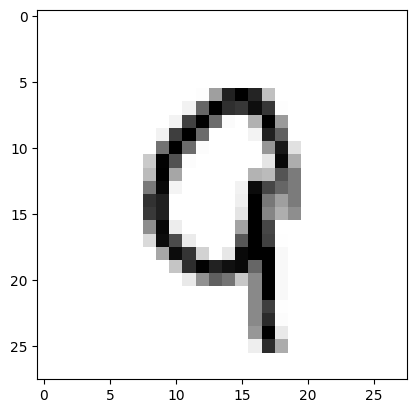

In [13]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)

images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

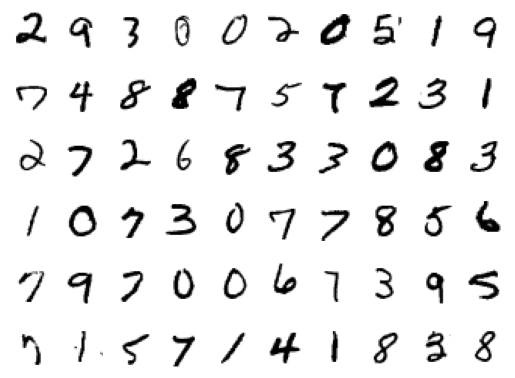

In [14]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),

            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),

            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),


            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),


            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [17]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
            Conv2d-3           [-1, 10, 24, 24]             900
              ReLU-4           [-1, 10, 24, 24]               0
            Conv2d-5           [-1, 20, 22, 22]           1,800
              ReLU-6           [-1, 20, 22, 22]               0
         MaxPool2d-7           [-1, 20, 11, 11]               0
            Conv2d-8           [-1, 10, 11, 11]             200
              ReLU-9           [-1, 10, 11, 11]               0
           Conv2d-10             [-1, 10, 9, 9]             900
             ReLU-11             [-1, 10, 9, 9]               0
           Conv2d-12             [-1, 20, 7, 7]           1,800

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [18]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [19]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.22349582612514496 Batch_id=468 Accuracy=53.48: 100%|██████████| 469/469 [00:16<00:00, 28.23it/s]



Test set: Average loss: 0.1830, Accuracy: 9464/10000 (94.64%)

EPOCH: 1


Loss=0.06643754988908768 Batch_id=468 Accuracy=95.99: 100%|██████████| 469/469 [00:16<00:00, 28.46it/s]



Test set: Average loss: 0.0882, Accuracy: 9716/10000 (97.16%)

EPOCH: 2


Loss=0.03055056743323803 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:16<00:00, 28.45it/s]



Test set: Average loss: 0.0598, Accuracy: 9811/10000 (98.11%)

EPOCH: 3


Loss=0.14644627273082733 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:16<00:00, 27.78it/s]



Test set: Average loss: 0.0502, Accuracy: 9833/10000 (98.33%)

EPOCH: 4


Loss=0.03900139778852463 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:19<00:00, 23.45it/s]



Test set: Average loss: 0.0506, Accuracy: 9831/10000 (98.31%)

EPOCH: 5


Loss=0.05277473106980324 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:19<00:00, 24.05it/s]



Test set: Average loss: 0.0515, Accuracy: 9840/10000 (98.40%)

EPOCH: 6


Loss=0.08529826253652573 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:17<00:00, 26.78it/s]



Test set: Average loss: 0.0482, Accuracy: 9838/10000 (98.38%)

EPOCH: 7


Loss=0.011479039676487446 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:17<00:00, 27.55it/s]



Test set: Average loss: 0.0400, Accuracy: 9868/10000 (98.68%)

EPOCH: 8


Loss=0.013145818375051022 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:16<00:00, 28.70it/s]



Test set: Average loss: 0.0402, Accuracy: 9874/10000 (98.74%)

EPOCH: 9


Loss=0.09680362790822983 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 27.72it/s]



Test set: Average loss: 0.0371, Accuracy: 9869/10000 (98.69%)

EPOCH: 10


Loss=0.05181979760527611 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:16<00:00, 28.67it/s]



Test set: Average loss: 0.0450, Accuracy: 9853/10000 (98.53%)

EPOCH: 11


Loss=0.03578398376703262 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:17<00:00, 27.12it/s]



Test set: Average loss: 0.0399, Accuracy: 9870/10000 (98.70%)

EPOCH: 12


Loss=0.008123859763145447 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:16<00:00, 28.46it/s]



Test set: Average loss: 0.0354, Accuracy: 9891/10000 (98.91%)

EPOCH: 13


Loss=0.03097606636583805 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:16<00:00, 28.09it/s]



Test set: Average loss: 0.0385, Accuracy: 9875/10000 (98.75%)

EPOCH: 14


Loss=0.003308287588879466 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:17<00:00, 27.25it/s]



Test set: Average loss: 0.0422, Accuracy: 9859/10000 (98.59%)

EPOCH: 15


Loss=0.03835500404238701 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 28.13it/s]



Test set: Average loss: 0.0333, Accuracy: 9902/10000 (99.02%)

EPOCH: 16


Loss=0.0021144570782780647 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:17<00:00, 27.06it/s]



Test set: Average loss: 0.0389, Accuracy: 9868/10000 (98.68%)

EPOCH: 17


Loss=0.005555819720029831 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:16<00:00, 28.54it/s]



Test set: Average loss: 0.0382, Accuracy: 9883/10000 (98.83%)

EPOCH: 18


Loss=0.0563545823097229 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:17<00:00, 26.34it/s]



Test set: Average loss: 0.0388, Accuracy: 9884/10000 (98.84%)

EPOCH: 19


Loss=0.008686450310051441 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:16<00:00, 28.08it/s]



Test set: Average loss: 0.0387, Accuracy: 9887/10000 (98.87%)



Text(0.5, 1.0, 'Test Accuracy')

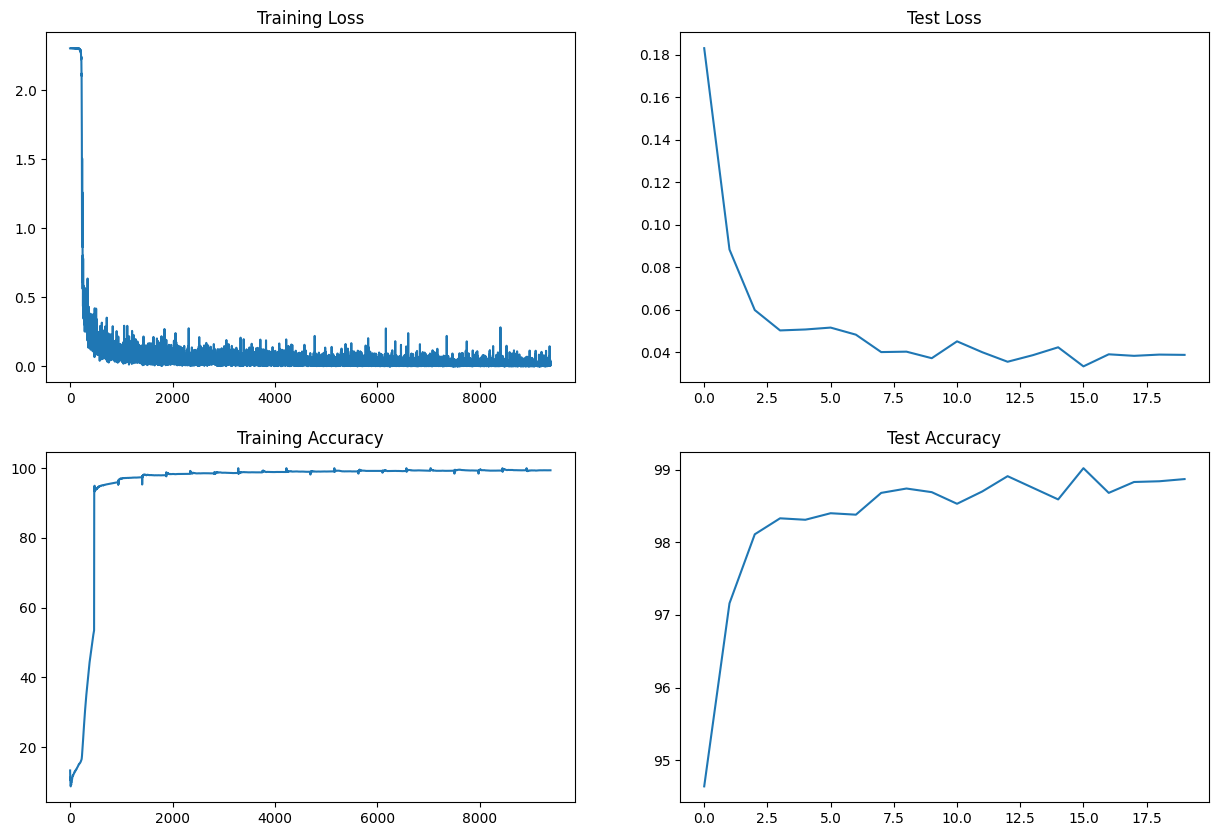

In [20]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")